# Sentiment Analysis Project

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import nltk
from nltk import download
import spacy 
from wordcloud import WordCloud
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    plot_confusion_matrix)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.model_selection import LearningCurve

## Preprocessing

### Data Import

In [111]:
path_dir = r"C:\Users\rmnlc\OneDrive - Università degli Studi di Milano\DSE-Unimi\Sentiment Analysis\Project\hate-speech-dataset\all_files/"

In [112]:
files = [file for file in os.listdir(path_dir) if file.endswith(".txt")]

In [113]:
paths = [path_dir + file for file in files] 
paths

['C:\\Users\\rmnlc\\OneDrive - Università degli Studi di Milano\\DSE-Unimi\\Sentiment Analysis\\Project\\hate-speech-dataset\\all_files/12834217_1.txt',
 'C:\\Users\\rmnlc\\OneDrive - Università degli Studi di Milano\\DSE-Unimi\\Sentiment Analysis\\Project\\hate-speech-dataset\\all_files/12834217_10.txt',
 'C:\\Users\\rmnlc\\OneDrive - Università degli Studi di Milano\\DSE-Unimi\\Sentiment Analysis\\Project\\hate-speech-dataset\\all_files/12834217_2.txt',
 'C:\\Users\\rmnlc\\OneDrive - Università degli Studi di Milano\\DSE-Unimi\\Sentiment Analysis\\Project\\hate-speech-dataset\\all_files/12834217_3.txt',
 'C:\\Users\\rmnlc\\OneDrive - Università degli Studi di Milano\\DSE-Unimi\\Sentiment Analysis\\Project\\hate-speech-dataset\\all_files/12834217_4.txt',
 'C:\\Users\\rmnlc\\OneDrive - Università degli Studi di Milano\\DSE-Unimi\\Sentiment Analysis\\Project\\hate-speech-dataset\\all_files/12834217_5.txt',
 'C:\\Users\\rmnlc\\OneDrive - Università degli Studi di Milano\\DSE-Unimi\\Senti

In [114]:
files[:] = (str[:-4] for str in files) 

In [115]:
messages = {}
errors = []
for file, path in list(zip(files, paths)):
    with open(path, "r") as txt:
        try:
            messages[file] = txt.readline().replace(",", "")
        except Exception as ex:
            errors.append((file, str(ex)))

In [116]:
errors_id = [id[0] for id in errors]

In [117]:
errors_id

['13491591_4',
 '13493456_1',
 '13500400_1',
 '13560796_1',
 '13572081_1',
 '13588794_3',
 '13595072_1',
 '13595072_5',
 '14061724_1',
 '14065492_1',
 '30422455_1',
 '30422455_2',
 '30443860_2',
 '30569404_3',
 '30586603_2',
 '30659540_3',
 '33500574_1',
 '33500574_2']

In [118]:
text_df = pd.DataFrame.from_dict(messages, orient = 'index').reset_index()
text_df.columns = ["File Name", "Text"]

In [119]:
annotations = pd.read_csv("hate-speech-dataset/annotations_metadata.csv")
annotations

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate
...,...,...,...,...,...
10939,33676864_5,734541,1388,0,noHate
10940,33677019_1,735154,1388,0,noHate
10941,33677019_2,735154,1388,0,noHate
10942,33677053_1,572266,1388,0,hate


In [120]:
annotations = annotations[~annotations['file_id'].isin(['errors_id'])]

In [121]:
dataset = pd.merge(left = annotations, right = text_df, left_on = 'file_id', right_on = "File Name")

In [122]:
dataset

,file_id,user_id,subforum_id,num_contexts,label,File Name,Text
0,12834217_1,572066,1346,0,noHate,12834217_1,As of March 13th 2014 the booklet had been d...
1,12834217_2,572066,1346,0,noHate,12834217_2,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,12834217_3,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,12834217_4,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,12834217_5,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...
...,...,...,...,...,...,...,...
10921,33676864_5,734541,1388,0,noHate,33676864_5,Billy - `` That guy would n't leave me alone ...
10922,33677019_1,735154,1388,0,noHate,33677019_1,Wish we at least had a Marine Le Pen to vote f...
10923,33677019_2,735154,1388,0,noHate,33677019_2,Its like the choices are white genocide candid...
10924,33677053_1,572266,1388,0,hate,33677053_1,Why White people used to say that sex was a si...


In [123]:
dataset['label'].unique()

array(['noHate', 'hate', 'idk/skip', 'relation'], dtype=object)

In [124]:
dataset = dataset.loc[(dataset['label'] != 'idk/skip') & (dataset['label'] !=  'relation')] #just binary classification

In [125]:
dataset = dataset.drop(columns=['file_id', 'user_id','subforum_id', 'num_contexts', 'File Name'])

In [126]:
dataset['label'] = (dataset['label'] == 'hate').astype(int)
dataset['label'].unique()

array([0, 1])

In [127]:
dataset.head()

,label,Text
0,0,As of March 13th 2014 the booklet had been d...
1,0,In order to help increase the booklets downloa...
2,0,( Simply copy and paste the following text int...
3,1,Click below for a FREE download of a colorfull...
4,0,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


### Data Cleaning

In [128]:
list(dataset['Text'])

['As of March 13th  2014  the booklet had been downloaded over 18300 times and counting .',
 'In order to help increase the booklets downloads  it would be great if all Stormfronters who had YouTube accounts  could display the following text in the description boxes of their uploaded YouTube videos .',
 '( Simply copy and paste the following text into your YouTube videos description boxes. )',
 'Click below for a FREE download of a colorfully illustrated 132 page e-book on the Zionist-engineered INTENTIONAL destruction of Western civilization .',
 "Click on the `` DOWNLOAD ( 7.42 MB ) '' green banner link .",
 'Booklet updated on Feb. 14th  2014 .',
 '( Now with over 18300 Downloads. )',
 "PDF file : http://www.mediafire.com/download/7p3p3goadvvqvsf/WNDebateBooklet_2-14-14.pdfMSWordfile:http://www.mediafire.com/download/psezkkk4d6a3wt1/WNDebateBooklet _ 2-14-14.docx Watch the 10 hour video version of `` The Zionist Attack on Western Civilization '' @ http://trutube.tv/video/14247/The-Z

In [129]:
x = dataset.loc[6910]["Text"]
x

'They re more like a virus than human ; they get inside a country and they taint it with their sickness and pretty soon the whole country goes to hell while the government tries to ban video games because knife crime  rapes and mindless violence has skyrocketed .'

In [130]:
### Clean ###
## 1. Removal of punctuation and capitlization
## 2. Remove Extra Spaces
## 3. Remove Mentions @ and links
## 4. Remove Numbers
## 5. remove single characters string
## 6. remove leading and trailing whitespaces

def clean(text):
    cleaned = text.lower()
    replacement = [
        #remove extra spaces
        ("\s+", " "),
        #remove mentions
        ("@[\w\-]+", " "),
        #remove links
        ("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " "),
        #remove ordinal numbers
        ("[0-9]+(?:st| st|nd| nd|rd| rd|th| th)", " "),
        #remove punctuation and numbers 
        ("[^a-zA-Z]", " "),
        # substitute whitespaces with a single space
        ("\s+", " "),
        ("\d+(\.\d+)?","num"),
        #remove single characters string
        (r"\b[a-zA-Z]\b", ""), 
        # remove leading and trailing whitespace
        ("^\s+|\s+?$"," ")
    ]
    
    for old, new in replacement:
         cleaned = re.sub(old, new, cleaned)
    return cleaned


### Load Spacy to perform Tokenization, Lemmatization and POS### 
nlp = spacy.load("en_core_web_sm")




In [48]:
dataset['Text_cleaned'] = dataset['Text'].apply(lambda x: clean(x))

In [49]:
dataset["spacy"] = dataset['Text_cleaned'].apply(lambda x: nlp(x))

In [50]:
dataset["Tokens"] = dataset['spacy'].apply(lambda x: [word.text for word in x])

In [51]:
dataset["POS"] = dataset['spacy'].apply(lambda x: [(word.lemma_, word.pos_) for word in x])

In [52]:
dataset['Lemmatized'] = dataset['spacy'].apply(lambda x: ' '.join([word.lemma_ for word in x]))

In [53]:
dataset.head()

,label,Text,Text_cleaned,spacy,Tokens,POS,Lemmatized
0,0,As of March 13th 2014 the booklet had been d...,as of march booklet had been downloaded over ...,"(as, of, march, , booklet, had, been, downloa...","[as, of, march, , booklet, had, been, downloa...","[(as, SCONJ), (of, ADP), (march, PROPN), ( , S...",as of march booklet have be download over ti...
1,0,In order to help increase the booklets downloa...,in order to help increase the booklets downloa...,"(in, order, to, help, increase, the, booklets,...","[in, order, to, help, increase, the, booklets,...","[(in, ADP), (order, NOUN), (to, PART), (help, ...",in order to help increase the booklet download...
2,0,( Simply copy and paste the following text int...,simply copy and paste the following text into...,"( , simply, copy, and, paste, the, following, ...","[ , simply, copy, and, paste, the, following, ...","[( , SPACE), (simply, ADV), (copy, VERB), (and...",simply copy and paste the follow text into -...
3,1,Click below for a FREE download of a colorfull...,click below for free download of colorfully ...,"(click, below, for, , free, download, of, , ...","[click, below, for, , free, download, of, , ...","[(click, VERB), (below, ADP), (for, ADP), ( , ...",click below for free download of colorfull...
4,0,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,click on the download mb green banner link,"(click, on, the, download, mb, green, banner, ...","[click, on, the, download, mb, green, banner, ...","[(click, VERB), (on, ADP), (the, DET), (downlo...",click on the download mb green banner link


In [55]:
dataset.to_pickle(r"C:\Users\rmnlc\OneDrive - Università degli Studi di Milano\DSE-Unimi\Sentiment Analysis\Project\data_cleaning.pkl")

In [133]:
dataset = pd.read_pickle(r"C:\Users\rmnlc\OneDrive - Università degli Studi di Milano\DSE-Unimi\Sentiment Analysis\Project\data_cleaning.pkl")

## Data Analysis

### Descriptive Analysis 

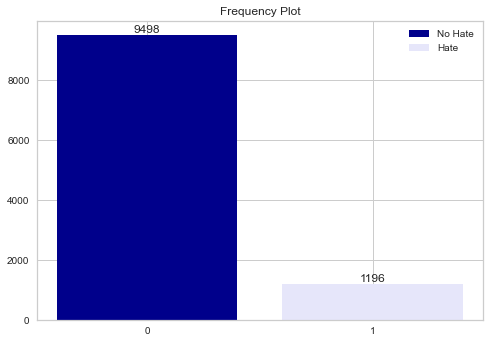

In [134]:
#### Hate-non hate message balance
#fig = dataset['label'].value_counts(sort = False).plot.bar(legend=True, )
freq = dataset['label'].value_counts()
fig, ax = plt.subplots()
plt1 = ax.bar('0', freq[0], label = "No Hate", color = "darkblue")
plt2 = ax.bar('1', freq[1], label = "Hate", color = "lavender")
for container in ax.containers:
    ax.bar_label(container)
ax.legend()
plt.title("Frequency Plot")
plt.savefig("frequency_plot.png")

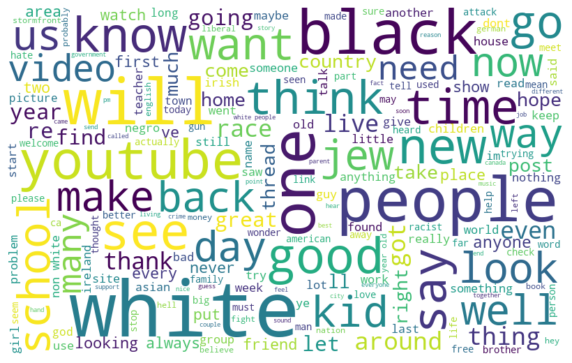

In [135]:
#### Most used words
all_words = ' '.join([text for text in dataset['Text_cleaned'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

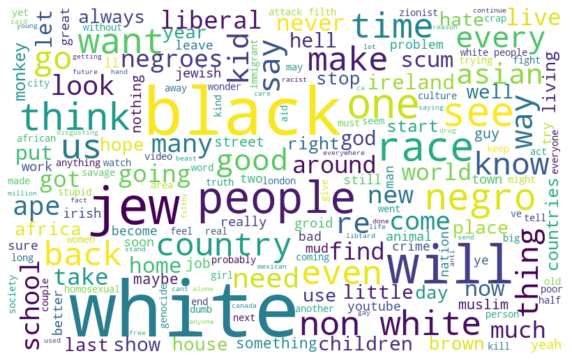

In [59]:
#### Most used in hate messages
hate_words = ' '.join([text for text in dataset.loc[(dataset['label']==1, 'Text_cleaned')]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(hate_words)
#random=0.30
fig = plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
fig.savefig('words_hate.png')

#### A more refined analysis Exploiting POS from Spacy

In [60]:
#### refined version for different POS 
def get_pos_words(pos):
    pos_words = []
    for sent in dataset['POS']:
        sent_words = []
        for word, x in sent:
            if(x == pos):
                sent_words.append(word)
        pos_words.append(sent_words)
    return pos_words

In [61]:
#get nouns for each sentence
dataset['Nouns'] = get_pos_words('NOUN')
#dataset['Nouns'] = dataset['Nouns'].apply(', '.join)

In [62]:
#get adjectives for each sentence
dataset['Adjectives'] = get_pos_words('ADJ')
#dataset['Adjectives'] = dataset['Adjectives'].apply(', '.join)

In [63]:
#get Verbs for each sentence
dataset['Verbs'] = get_pos_words('VERB')
#dataset['Verbs'] = dataset['Verbs'].apply(', '.join)

In [64]:
dataset.head()

,label,Text,Text_cleaned,spacy,Tokens,POS,Lemmatized,Nouns,Adjectives,Verbs
0,0,As of March 13th 2014 the booklet had been d...,as of march booklet had been downloaded over ...,"(as, of, march, , booklet, had, been, downloa...","[as, of, march, , booklet, had, been, downloa...","[(as, SCONJ), (of, ADP), (march, PROPN), ( , S...",as of march booklet have be download over ti...,"[booklet, time]",[],"[download, count]"
1,0,In order to help increase the booklets downloa...,in order to help increase the booklets downloa...,"(in, order, to, help, increase, the, booklets,...","[in, order, to, help, increase, the, booklets,...","[(in, ADP), (order, NOUN), (to, PART), (help, ...",in order to help increase the booklet download...,"[order, booklet, download, stormfronter, youtu...","[great, uploaded]","[help, increase, would, could, display, follow]"
2,0,( Simply copy and paste the following text int...,simply copy and paste the following text into...,"( , simply, copy, and, paste, the, following, ...","[ , simply, copy, and, paste, the, following, ...","[( , SPACE), (simply, ADV), (copy, VERB), (and...",simply copy and paste the follow text into -...,"[text, video, description, box]",[youtube],"[copy, paste, follow]"
3,1,Click below for a FREE download of a colorfull...,click below for free download of colorfully ...,"(click, below, for, , free, download, of, , ...","[click, below, for, , free, download, of, , ...","[(click, VERB), (below, ADP), (for, ADP), ( , ...",click below for free download of colorfull...,"[download, page, book, zionist, destruction, c...","[free, intentional, western]","[click, illustrate, engineer]"
4,0,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,click on the download mb green banner link,"(click, on, the, download, mb, green, banner, ...","[click, on, the, download, mb, green, banner, ...","[(click, VERB), (on, ADP), (the, DET), (downlo...",click on the download mb green banner link,"[download, mb, banner, link]",[green],[click]


In [65]:
dataset.to_pickle(r"C:\Users\rmnlc\OneDrive - Università degli Studi di Milano\DSE-Unimi\Sentiment Analysis\Project\preprocess.pkl")

In [66]:
dataset = pd.read_pickle(r"C:\Users\rmnlc\OneDrive - Università degli Studi di Milano\DSE-Unimi\Sentiment Analysis\Project\preprocess.pkl")

##### Nouns

In [67]:
#### Top 30 nouns Hate
freq_nouns_Hate = {}
for set in dataset.loc[dataset['label'] == 1, 'Nouns']:
    for word in set:
        if word in freq_nouns_Hate:
            freq_nouns_Hate[word] += 1
        else: freq_nouns_Hate[word] = 1
top_freq_nouns_Hate = {k: v for k, v in sorted(freq_nouns_Hate.items(), key=lambda item: item[1], reverse=True)[:30]}

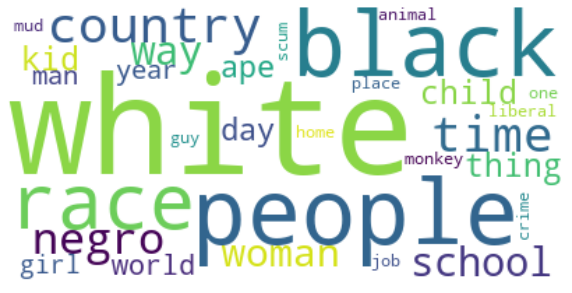

In [68]:
top30_nouns_Hate = ' '.join([text for text in top_freq_nouns_Hate.keys()])
wordcloud = WordCloud(random_state=212, background_color='white').generate(top30_nouns_Hate)
#random=0.30
fig = plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
fig.savefig("top_30nouns")

##### Adjectives

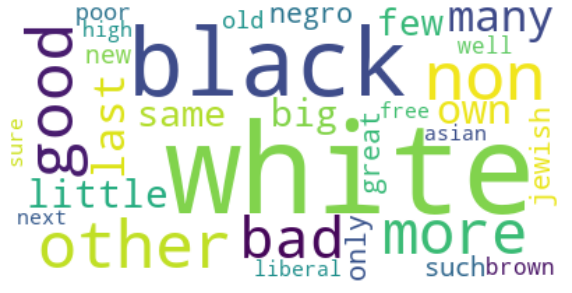

In [69]:
#### Top 30 Adjectives Hate
freq_adj_Hate = {}
for set in dataset.loc[dataset['label'] == 1, 'Adjectives']:
    for word in set:
        if word in freq_adj_Hate:
            freq_adj_Hate[word] += 1
        else: freq_adj_Hate[word] = 1
top_freq_adj_Hate = {k: v for k, v in sorted(freq_adj_Hate.items(), key=lambda item: item[1], reverse=True)[:30]}

#top30_adj_Hate = ' '.join([text for text in top_freq_adj_Hate.keys()])
wordcloud = WordCloud(random_state=12, background_color='white').generate_from_frequencies(top_freq_adj_Hate)
#random=0.30
fig = plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
fig.savefig('top30_adj.png')

##### Verbs

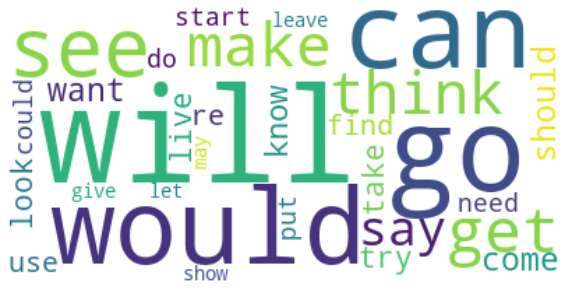

In [70]:
#### Top 30 Verbs Hate
freq_verbs_Hate = {}
for set in dataset.loc[dataset['label'] == 1, 'Verbs']:
    for word in set:
        if word in freq_verbs_Hate:
            freq_verbs_Hate[word] += 1
        else: freq_verbs_Hate[word] = 1
top_freq_verbs_Hate = {k: v for k, v in sorted(freq_verbs_Hate.items(), key=lambda item: item[1], reverse=True)[:30]}

#top30_adj_Hate = ' '.join([text for text in top_freq_adj_Hate.keys()])
wordcloud = WordCloud(random_state=12, background_color='white').generate_from_frequencies(top_freq_verbs_Hate)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Models for Classification

In [136]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(dataset['Lemmatized'])
y = dataset['label']
X

<10694x12006 sparse matrix of type '<class 'numpy.float64'>'
	with 140413 stored elements in Compressed Sparse Row format>

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.4, stratify = y)

### Naive Bayes

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      3800
           1       0.14      0.08      0.10       478

    accuracy                           0.84      4278
   macro avg       0.51      0.51      0.51      4278
weighted avg       0.81      0.84      0.82      4278



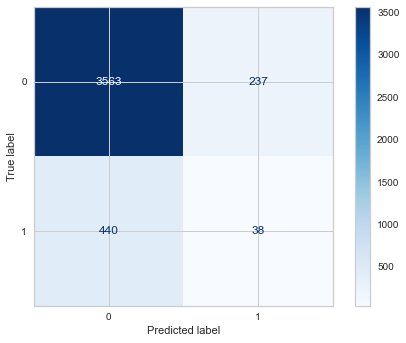

In [138]:
naive_classifier = ComplementNB()
naive_classifier.fit(X_train, y_train)
y_pred_naive = naive_classifier.predict(X_test)
print(classification_report(y_test,y_pred_naive))
ConfusionMatrixDisplay.from_estimator(naive_classifier, X_test, y_test, cmap = 'Blues')

In [139]:
f1_naive = f1_score(y_test, y_pred_naive)
f1_naive

0.10092961487383799

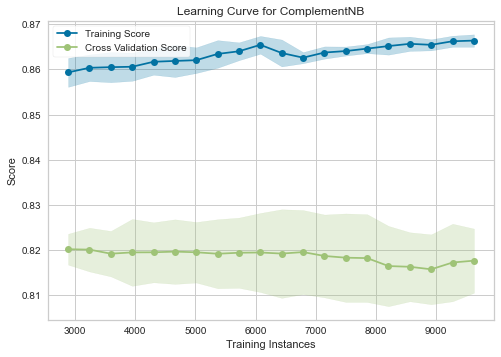

<AxesSubplot:title={'center':'Learning Curve for ComplementNB'}, xlabel='Training Instances', ylabel='Score'>

In [140]:
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.3, 1, 20)

model = ComplementNB()
visualizer = LearningCurve(model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, shuffle=True)

vis = plt.figure()
visualizer.fit(X, y)
#vis.savefig("Learning curve UnderSampled dataset.png")
visualizer.show()

### Logistic Regression

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3800
           1       0.68      0.04      0.08       478

    accuracy                           0.89      4278
   macro avg       0.78      0.52      0.51      4278
weighted avg       0.87      0.89      0.85      4278



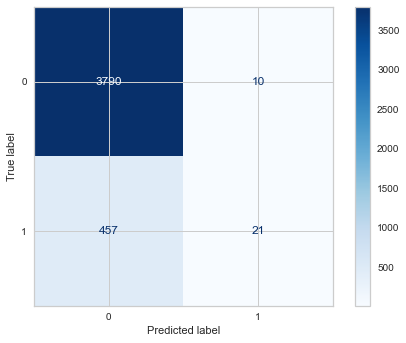

In [141]:
logistic = LogisticRegression().fit(X_train,y_train)
y_pred_logistic = logistic.predict(X_test)
print(classification_report(y_test,y_pred_logistic))
ConfusionMatrixDisplay.from_estimator(logistic, X_test, y_test, cmap="Blues")

In [142]:
f1_logistic_vanilla = f1_score(y_test, y_pred_logistic)
f1_logistic_vanilla

0.0825147347740668

In [ ]:
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.3, 1, 20 )

model = LogisticRegression()
visualizer = LearningCurve(model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, shuffle=True)

vis = plt.figure()
visualizer.fit(X, y)
#vis.savefig("Learning curve UnderSampled dataset.png")
visualizer.show()

## Over Sampling with SMOTE

In [ ]:
X_smote, y_smote = SMOTE(sampling_strategy='minority', random_state=123).fit_resample(X, y)
y_smote.value_counts()

In [ ]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, random_state=123, test_size=0.4, stratify = y_smote)
logistic_smote = LogisticRegression().fit(X_train_smote,y_train_smote)
y_pred_smote = logistic_smote.predict(X_test_smote)
print(classification_report(y_test_smote,y_pred_smote))
ConfusionMatrixDisplay.from_estimator(logistic_smote, X_test_smote, y_test_smote, cmap="Blues")

In [ ]:
f1_smote = f1_score(y_test_smote, y_pred_smote)
f1_smote

In [ ]:
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.3, 1, 20)

model = LogisticRegression()
visualizer = LearningCurve(model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, shuffle=True)

vis = plt.figure()
visualizer.fit(X_smote, y_smote)
vis.savefig("Learning curve UnderSampled dataset.png")
visualizer.show(outpath='learning_curve_smote.png')

## Under Sampling

In [ ]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=123)
X_under,y_under = rus.fit_resample(X, y)
y_under.value_counts()

In [ ]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, random_state=123, test_size=0.2, stratify = y_under)
logistic_under = LogisticRegression().fit(X_train_under,y_train_under)
y_pred_under = logistic_under.predict(X_test_under)
print(classification_report(y_test_under,y_pred_under))
ConfusionMatrixDisplay.from_estimator(logistic_under, X_test_under, y_test_under, cmap="Blues")

In [ ]:
f1_rus = f1_score(y_test_under, y_pred_under)
f1_rus

In [ ]:
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.3, 1, 20)

model = LogisticRegression()
visualizer = LearningCurve(model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, shuffle=True)

visualizer.fit(X_under, y_under)
visualizer.show(outpath='learning_curve_undersampled.png')